**預計項目**

1. 104 年起火原因排行
2. 104 縱火縣市排名
3. 104 縱火縣市數量地圖
4. 104 縱火鄉鎮市區排名
5. 104 縱火鄉鎮市區數量地圖

--------------以上完成-------------

6. 104 縱火案件報案時間分佈


---

 2. 各縣市平均報案到抵達所花時間(box fig)
  
- 熱度圖
 1. 各縣市 x 原因
 2. 各縣市 x 報案時間
 3. 
  
- 地圖
 1. 縱火案件數
 2. 縱火案件數/火災案件數
 3. 縱火案件數/人口數
 4. 縱火案件數/人口密度
 5. 縱火案件數/公司行號數目



In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import geopandas as gp
import subprocess
from IPython.display import Markdown, display
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = 'Noto Sans CJK TC'
# gp.__version__

## 方便 markdown 寫作使用

In [2]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
#     display(Markdown(df_formatted.to_csv to_csv(sep="|", index=False)))
    return df_formatted.to_csv(sep="|", index=False)

# 讀取台灣地圖資料
### 欄位
COUNTYCODE, COUNTYID, COUNTYNAME, TOWNCODE, TOWNENG, TOWNID, TOWNNAME, geometry

In [3]:
#全台灣村里界圖
taiwan_villages_shp = gp.read_file("../GeoPandas_GettingStart/town_shp/TOWN_MOI_1060525.shp")

In [4]:
#全台灣鄉鎮市區界圖
taiwan_town_shp = taiwan_villages_shp.dissolve('TOWNID', as_index=False)
taiwan_town_shp

,TOWNID,geometry,TOWNCODE,COUNTYNAME,TOWNNAME,TOWNENG,COUNTYID,COUNTYCODE
0,A01,"POLYGON ((121.5697062800001 25.07629222800006,...",63000010,臺北市,松山區,Songshan District,A,63000
1,A02,"POLYGON ((121.543841724 25.04490669700004, 121...",63000030,臺北市,大安區,Daan District,A,63000
2,A03,"POLYGON ((121.5134137450001 25.04939843500006,...",63000050,臺北市,中正區,Zhongzheng District,A,63000
3,A05,"POLYGON ((121.5052060700001 25.04949036400006,...",63000070,臺北市,萬華區,Wanhua District,A,63000
4,A09,"POLYGON ((121.5141047090001 25.07941577800005,...",63000060,臺北市,大同區,Datong District,A,63000
5,A10,"POLYGON ((121.5414663030001 25.09287088400004,...",63000040,臺北市,中山區,Zhongshan District,A,63000
6,A11,"POLYGON ((121.5972524900001 25.01438526800007,...",63000080,臺北市,文山區,Wenshan District,A,63000
7,A13,"POLYGON ((121.614250201 25.06451252200009, 121...",63000090,臺北市,南港區,Nangang District,A,63000
8,A14,"POLYGON ((121.5935900530001 25.11514551600004,...",63000100,臺北市,內湖區,Neihu District,A,63000
9,A15,"POLYGON ((121.580883371 25.19535329300004, 121...",63000110,臺北市,士林區,Shilin District,A,63000


# 火災事件資料前處理
1. 讀取、合併各縣市資料
2. "火災原因"關聯分組
3. "鄉鎮市區" column name 字串替換 & 缺字補充

In [5]:
# 1. 讀取、合併各縣市資料

# 建立各縣市火災檔案清單
list_xls_file = []
floder_path = '104年火災事件資料/'
for i in os.listdir(floder_path):
    list_xls_file.append(floder_path+i)
      
# 合併各縣市火災資料
df_taiwan_fire_event = pd.DataFrame()
for xls in list_xls_file:
    df = pd.read_excel(
                  xls, #list_xls_file[3],
                  skiprows=[0] #這份文件的 row1 不是 index，是文件名稱，所以要跳過
    )
    #print('{} 案件數量={}, '.format(df_taiwan_fire_event['縣市'].unique(), df_taiwan_fire_event.index.size), end='')
    df_taiwan_fire_event = pd.concat([df_taiwan_fire_event, df])

### 每個縣市各抽一份資料出來觀察格式差異

In [6]:
tab_str = pandas_df_to_markdown_table(
df_taiwan_fire_event.reset_index().drop(axis=1,labels='index').
                                groupby(by='縣市',as_index=False).nth(1)
)
print('|'+tab_str.replace('\n','|\n|')+'|')

|縣市|鄉、鎮、市、區|街、路段|火災案件編號|報案時間 (月：日：時：分) |抵達時間 (月：日：時：分) |起火原因|死亡人數|受傷人數|
|---|---|---|---|---|---|---|---|---|
|高雄市|高雄市旗津區德利造船廠(CERIBU漁船)|－|315C20O2|03：20：141：59|03：20：15：106|施工不慎|0|0|
|新北市|淡水區|竿蓁二街|H15A08D1| 01:08:03:36| 01:08:03:42|電氣因素|0|0|
|臺北市|南港區|昆陽街|A15A04J1|2015-01-04 09:53:28.593000|2015-01-04 09:58:00|其他|0|0|
|桃園市|大溪區|瑞源里番仔寮|I15A03I1|01 : 03 : 08 : 59|01 : 03 : 09 : 13|燃燒雜草、垃圾|0|0|
|臺中市|中區|成功路|E15A11C1|01：11：02：31|01：11：02：53|縱火|0|0|
|臺南市|中西區|中山路|G15A01X1|01:01:23:32|01:01:23:36|電氣因素|0|0|
|宜蘭縣|南澳鄉|金洋路|T15A04R1|01:04:17:49|01:04:18:05|烘乾機作業不慎|0|0|
|新竹縣|北埔鄉|水祭村8鄰麻布樹排|J15A13I1|2016-01-13 08:18:00|2016-01-13 08:23:00|敬神祭祖|0|0|
|苗栗縣|頭份市|市場內|K15A20B1|01：20：02：01|01：20：02：04|縱火|0|0|
|彰化縣|芳苑鄉|芳漢路芳二段|M15A03P1|01:03:15:40|01:03:15:51|遺留火種|0|0|
|南投縣|魚池鄉|水秀街|N15A16G1|01:16:06:03 |01:16:06:21|瓦斯漏氣或爆炸|0|0|
|雲林縣|口湖鄉|埔南村|O15A02F1|01:02:05:30|01:02:05:39|電氣因素|0|0|
|嘉義縣|朴子市|四維路2段|P15A06M1|01：06：12：11|01：06：12：14|施工不慎|0|0|
|屏東縣|崁頂鄉|復興路|S15A01N1|01:01:14:00|01:01:14:08|縱火|0|0|
|臺東縣|臺東市|平等街|V15A25

In [7]:
# 嘗試處理時間 parser
df_taiwan_fire_event.rename(columns={"報案時間 (月：日：時：分) ":"報案時間",
                                     "抵達時間 (月：日：時：分) ":"抵達時間"},
                            inplace=True)
# df_taiwan_fire_event.rename(columns={"報案時間 (月：日：時：分)":"報案時間"})
# df_taiwan_fire_event.columns

In [8]:
# df_taiwan_fire_event['報案時間'].str.replace('：',':')

In [9]:
# 2. "火災原因"關聯分組

# 火災事件關聯分組表
dict_fire_event = {
    '自殺':['自殺','自焚'],
    '蠟燭':['蠟燭','燈燭'],
    '縱火':['縱火','疑似縱火','人為縱火'],
    '瓦斯':['瓦斯','瓦斯外洩','瓦斯漏氣或爆炸','洩漏液化石油氣','洩漏液化瓦斯','瓦斯漏氣爆炸','瓦斯灌充填打火機不慎'],
    '機械設備':['機械設備','機械故障'],
    '電氣因素':['電氣因素','電氣因素(不含車輛)'],
    '乾燥作業':['乾燥作業','烘乾機作業不慎','烤火'],
    '敬神祭祖':['敬神祭祖','敬神、祭祖','敬神','祭祖'],
    '爐火烹調':['爐火烹調','爐火不慎','爐火烹調油鍋起火','爐火烹調乾燒'],
    '車輛因素':['車輛因素','車輛電氣因素','車輛機械因素','引擎排煙管高溫','車輛人為疏忽','車輛電氣系統','車輛燃料系統',],
    '燃燒廢棄物':['燃燒廢棄物','燃燒雜草、垃圾','自清','燒廢料','燃燒木材不慎','整地','引燃汽油','引燃枯草'],
    '燃放爆竹煙火':['燃放爆竹','燃放爆竹煙火','施放爆竹煙火'],
    '易燃液體接觸火源':['易燃液體接觸火源','易燃品自燃','化學物品','柴油洩漏接觸熱源','絕緣油接觸高溫','易燃液體'],
    '其他或不明':['其他或不明','其他','其它','原因不明','不明']
}

print("原先所有類別數量 = {}".format(len(df_taiwan_fire_event['起火原因'].unique())))

# 關聯分組字串替換
for key in dict_fire_event:
    df_taiwan_fire_event['起火原因'].replace(
        to_replace = dict_fire_event[key],
        value = key, inplace=True)

df_fire_cause_count = df_taiwan_fire_event.groupby(by = ['起火原因'], squeeze = True).count()
df_fire_cause_count.iloc[:,0:1].sort_values(
                    by = df_fire_cause_count.columns[0],
                    ascending = False)
print("關聯分組類別數量 = {}".format(len(df_fire_cause_count.index.unique())))
print(df_fire_cause_count.index.values)

原先所有類別數量 = 62
關聯分組類別數量 = 25
['乾燥作業' '交通事故' '其他或不明' '天然災害' '敬神掃墓祭祖' '敬神祭祖' '施工不慎' '易燃液體接觸火源' '機械設備'
 '汙泥過熱' '燃放爆竹煙火' '燃燒廢棄物' '爐火烹調' '玩火' '瓦斯' '縱火' '自殺' '菸蒂' '蠟燭' '車輛因素' '遺留火種'
 '除蜂不慎' '電暖器引燃可燃物' '電氣因素' '點蚊香不慎引火']


In [10]:
# 3. "鄉鎮市區" column name 字串替換 & 缺字補充

#'鄉、鎮、市、區'不能 query
df_taiwan_fire_event.rename_axis({'鄉、鎮、市、區':'鄉鎮市區'}, axis=1, inplace=True)

dict_TOWNNAME = {
    '中山區':['中山區','中山'],
    '七堵區':['七堵區','七堵'],
    '中正區':['中正區','中正'],
    '仁愛區':['仁愛區','仁愛'],
    '信義區':['信義區','信義'],
    '安樂區':['安樂區','安樂'],
    '暖暖區':['暖暖區','暖暖'],
    '臺西鄉':['臺西鄉','臺西','台西鄉','台西'],
}

for key in dict_TOWNNAME:
    df_taiwan_fire_event['鄉鎮市區'].replace(
            to_replace = dict_TOWNNAME[key],
            value = key, inplace=True)

In [11]:
# df_taiwan_fire_event.query('鄉鎮市區=="大甲區"')
# taiwan_town_shp.query('TOWNNAME=="大甲區"')
print("鄉鎮市區總數 = {}".format(taiwan_town_shp.index.size))

鄉鎮市區總數 = 368


In [12]:
# 求兩個資料集的差異
set(
    df_taiwan_fire_event['鄉鎮市區'].unique()
).difference(set(taiwan_town_shp['TOWNNAME']))

{'台南市南區鯤鯓湖南側水道(CTR-CI0031舢舨)',
 '高雄市前鎮漁港(益大68號)',
 '高雄市旗津區德利造船廠(CERIBU漁船)',
 '高雄港121號碼頭(華維1號貨輪)',
 '高雄港32號碼頭(編號10-8號堆高機)',
 '高雄港78號碼頭(編號601號堆高機)'}

## 完成資料前處理和檢查

In [13]:
# df_taiwan_fire_event.sort_values(by='受傷人數', ascending=False)
# taiwan_town_shp[['COUNTYNAME','TOWNNAME']]
# pd.Series(index = df_taiwan_fire_event['起火原因'].unique(),
#           data  = df_taiwan_fire_event.query('縣市=="臺中市" and 鄉鎮市區=="潭子區"')["起火原因"].value_counts()).fillna(0)

In [14]:
# df_raw.query('"潭子"鄉鎮市區')
# df_taichug_region1 = df_taiwan_fire_event.query('"大雅區"==鄉鎮市區 or "神岡區"==鄉鎮市區 or "潭子區"==鄉鎮市區 or "豐原區"==鄉鎮市區')

## 全台火災原因排名表

In [15]:
df_fire_event_rank_of_TW = (df_taiwan_fire_event
        .groupby(by=['起火原因']).count().iloc[:,[0]] #計算各原因事件數目
        .rename(columns={'縣市':'數量'}) #體換成合理的 column name
        .sort_values(by=['數量'],ascending=False) #排序
        .T #轉置
    )
display(df_fire_event_rank_of_TW)

# 產生寫文章用的 MD table
pandas_df_to_markdown_table(df_fire_event_rank_of_TW)

起火原因,電氣因素,縱火,其他或不明,菸蒂,遺留火種,爐火烹調,車輛因素,施工不慎,燃燒廢棄物,敬神祭祖,...,交通事故,易燃液體接觸火源,玩火,敬神掃墓祭祖,乾燥作業,汙泥過熱,除蜂不慎,電暖器引燃可燃物,天然災害,點蚊香不慎引火
數量,576,270,164,148,104,72,46,37,31,31,...,18,15,14,14,2,1,1,1,1,1


'電氣因素|縱火|其他或不明|菸蒂|遺留火種|爐火烹調|車輛因素|施工不慎|燃燒廢棄物|敬神祭祖|瓦斯|機械設備|燃放爆竹煙火|自殺|蠟燭|交通事故|易燃液體接觸火源|玩火|敬神掃墓祭祖|乾燥作業|汙泥過熱|除蜂不慎|電暖器引燃可燃物|天然災害|點蚊香不慎引火\n---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---\n576|270|164|148|104|72|46|37|31|31|29|27|26|24|19|18|15|14|14|2|1|1|1|1|1\n'

## （各縣市 X 各種起火原因）數量表

In [16]:
df_town_fire_cause = pd.crosstab(index=[df_taiwan_fire_event['縣市'],
                                        df_taiwan_fire_event['鄉鎮市區']
                                       ],
                                columns=df_taiwan_fire_event["起火原因"])
# df_town_fire_cause.to_json("/tmp/（各縣市 X 各種起火原因）數量表.json", orient='split', force_ascii=False)

## 各縣市縱火排名表

In [17]:
# 地區縱火排名表
df_Arson_rank = (df_town_fire_cause.groupby(by=['縣市','鄉鎮市區']).sum()[['縱火']]
                                   .sort_values(by=['縱火'], ascending=False)
                )
# df_Arson_rank['縱火'].values
display(df_Arson_rank.groupby(by=['縣市']).sum().sort_values(by=['縱火'], ascending=False).T)
display(df_Arson_rank.sort_values(by=['縱火'], ascending=False)[0:20].T)

縣市,桃園市,屏東縣,臺南市,臺中市,彰化縣,高雄市,臺北市,嘉義縣,雲林縣,苗栗縣,...,南投縣,宜蘭縣,新竹縣,基隆市,澎湖縣,新竹市,嘉義市,金門縣,臺中港,連江縣
起火原因,,,,,,,,,,,,,,,,,,,,,
縱火,48,38,24,24,17,16,14,13,12,11,...,6,6,5,3,3,2,1,1,0,0


縣市   桃園市         臺東縣 屏東縣 雲林縣 桃園市 臺南市 桃園市 臺北市 彰化縣     苗栗縣 臺南市 屏東縣     臺南市 臺中市  \
鄉鎮市區 中壢區 蘆竹區 平鎮區 臺東市 屏東市 虎尾鎮 桃園區 關廟區 觀音區 信義區 秀水鄉 鹿港鎮 苗栗市 永康區 枋寮鄉 琉球鄉 新市區 太平區   
起火原因                                                                           
縱火     9   8   6   6   6   5   5   5   5   4   4   4   4   4   4   3   3   3   

縣市            
鄉鎮市區 大甲區 沙鹿區  
起火原因          
縱火     3   3

In [18]:
print(pandas_df_to_markdown_table(df_Arson_rank.sort_values(by=['縱火'], ascending=False)[0:100].T))

桃園市|桃園市|桃園市|臺東縣|屏東縣|雲林縣|桃園市|臺南市|桃園市|臺北市|彰化縣|彰化縣|苗栗縣|臺南市|屏東縣|屏東縣|臺南市|臺中市|臺中市|臺中市|桃園市|屏東縣|花蓮縣|桃園市|臺南市|臺北市|桃園市|屏東縣|花蓮縣|臺中市|臺中市|屏東縣|花蓮縣|嘉義縣|嘉義縣|嘉義縣|臺南市|高雄市|嘉義縣|南投縣|嘉義縣|高雄市|桃園市|南投縣|桃園市|彰化縣|桃園市|高雄市|高雄市|屏東縣|屏東縣|屏東縣|臺北市|雲林縣|彰化縣|苗栗縣|臺中市|臺北市|新北市|臺南市|新竹縣|新竹縣|臺南市|高雄市|屏東縣|宜蘭縣|屏東縣|屏東縣|彰化縣|臺南市|高雄市|彰化縣|彰化縣|屏東縣|基隆市|宜蘭縣|臺北市|宜蘭縣|雲林縣|基隆市|臺北市|高雄市|臺南市|屏東縣|雲林縣|新北市|宜蘭縣|彰化縣|雲林縣|彰化縣|宜蘭縣|宜蘭縣|基隆市|新北市|屏東縣|屏東縣|屏東縣|屏東縣|屏東縣|臺南市
中壢區|蘆竹區|平鎮區|臺東市|屏東市|虎尾鎮|桃園區|關廟區|觀音區|信義區|秀水鄉|鹿港鎮|苗栗市|永康區|枋寮鄉|琉球鄉|新市區|太平區|大甲區|沙鹿區|龍潭區|長治鄉|吉安鄉|八德區|七股區|大安區|楊梅區|內埔鄉|秀林鄉|北屯區|清水區|恆春鎮|萬榮鄉|布袋鎮|朴子市|水上鄉|北區|岡山區|大林鎮|水里鄉|竹崎鄉|大樹區|龜山區|埔里鎮|新屋區|彰化市|大溪區|前鎮區|仁武區|東港鎮|春日鄉|新埤鄉|萬華區|西螺鎮|埔心鄉|頭份市|東區|內湖區|板橋區|東區|湖口鄉|關西鎮|下營區|三民區|萬丹鄉|宜蘭市|麟洛鄉|潮州鎮|二林鎮|仁德區|內門區|溪湖鎮|員林市|滿州鄉|七堵區|冬山鄉|松山區|三星鄉|莿桐鄉|安樂區|文山區|梓官區|南化區|林邊鄉|崙背鄉|林口區|礁溪鄉|芬園鄉|東勢鄉|芳苑鄉|蘇澳鎮|頭城鎮|仁愛區|中和區|枋山鄉|九如鄉|新園鄉|來義鄉|崁頂鄉|南區
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

In [19]:
# 計算百分比
(df_Arson_rank.groupby(by=['縣市']).sum()
 .sort_values(by=['縱火'], ascending=False)
 .apply(lambda x: 100*x/float(x.sum())).T
)

縣市,桃園市,屏東縣,臺南市,臺中市,彰化縣,高雄市,臺北市,嘉義縣,雲林縣,苗栗縣,...,南投縣,宜蘭縣,新竹縣,基隆市,澎湖縣,新竹市,嘉義市,金門縣,臺中港,連江縣
起火原因,,,,,,,,,,,,,,,,,,,,,
縱火,17.777778,14.074074,8.888889,8.888889,6.296296,5.925926,5.185185,4.814815,4.444444,4.074074,...,2.222222,2.222222,1.851852,1.111111,1.111111,0.740741,0.37037,0.37037,0.0,0.0


## 各[ 縣市, 鄉鎮市區 ] 縱火數量地圖

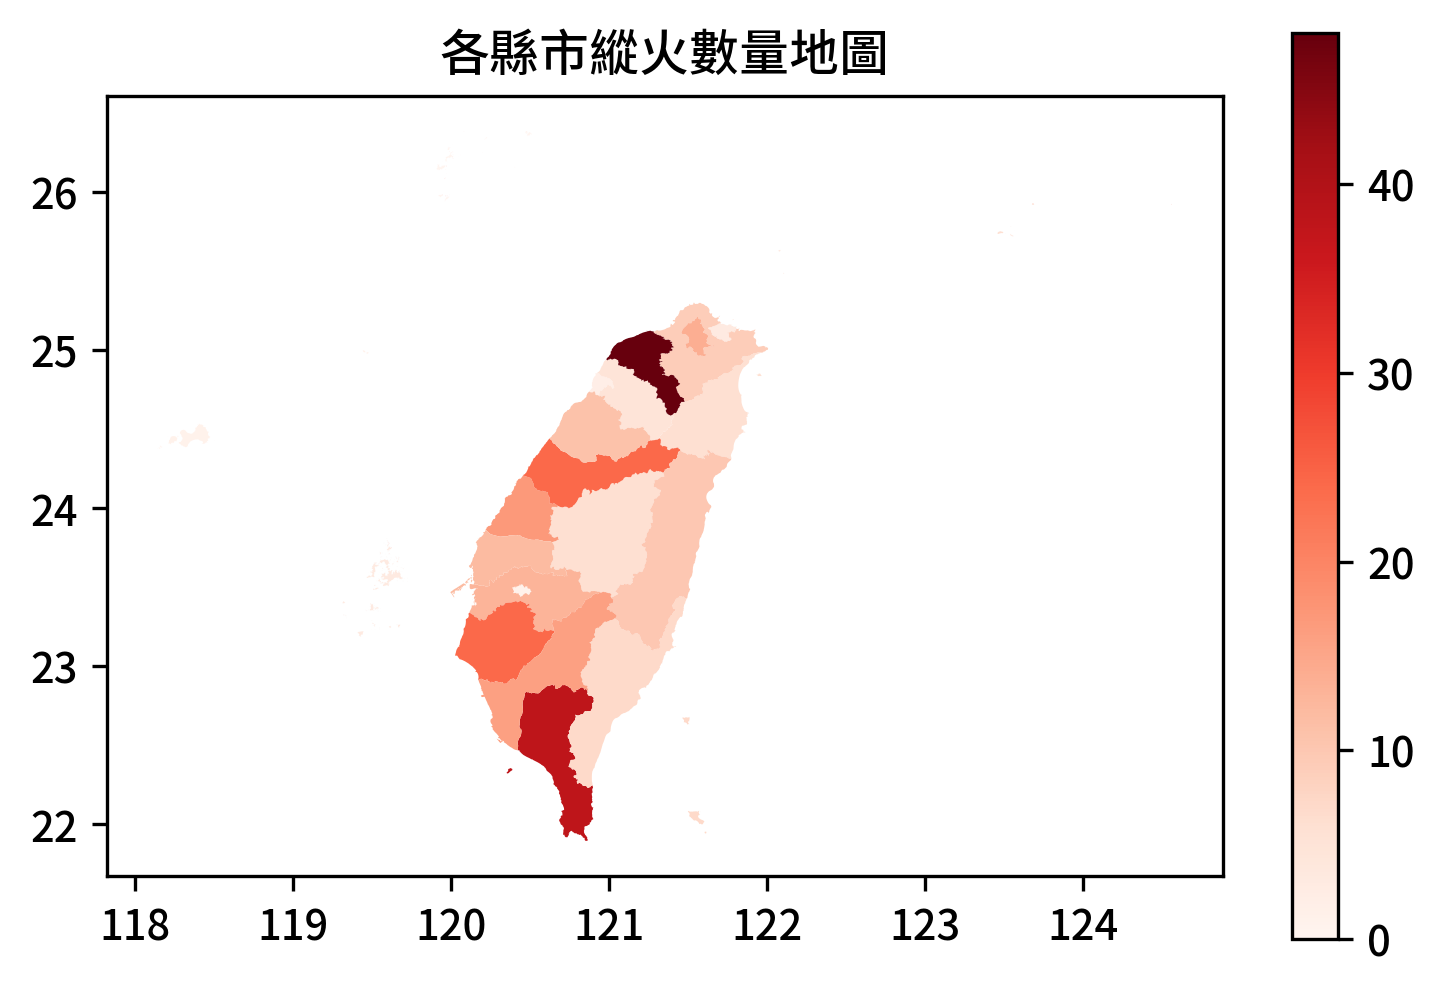

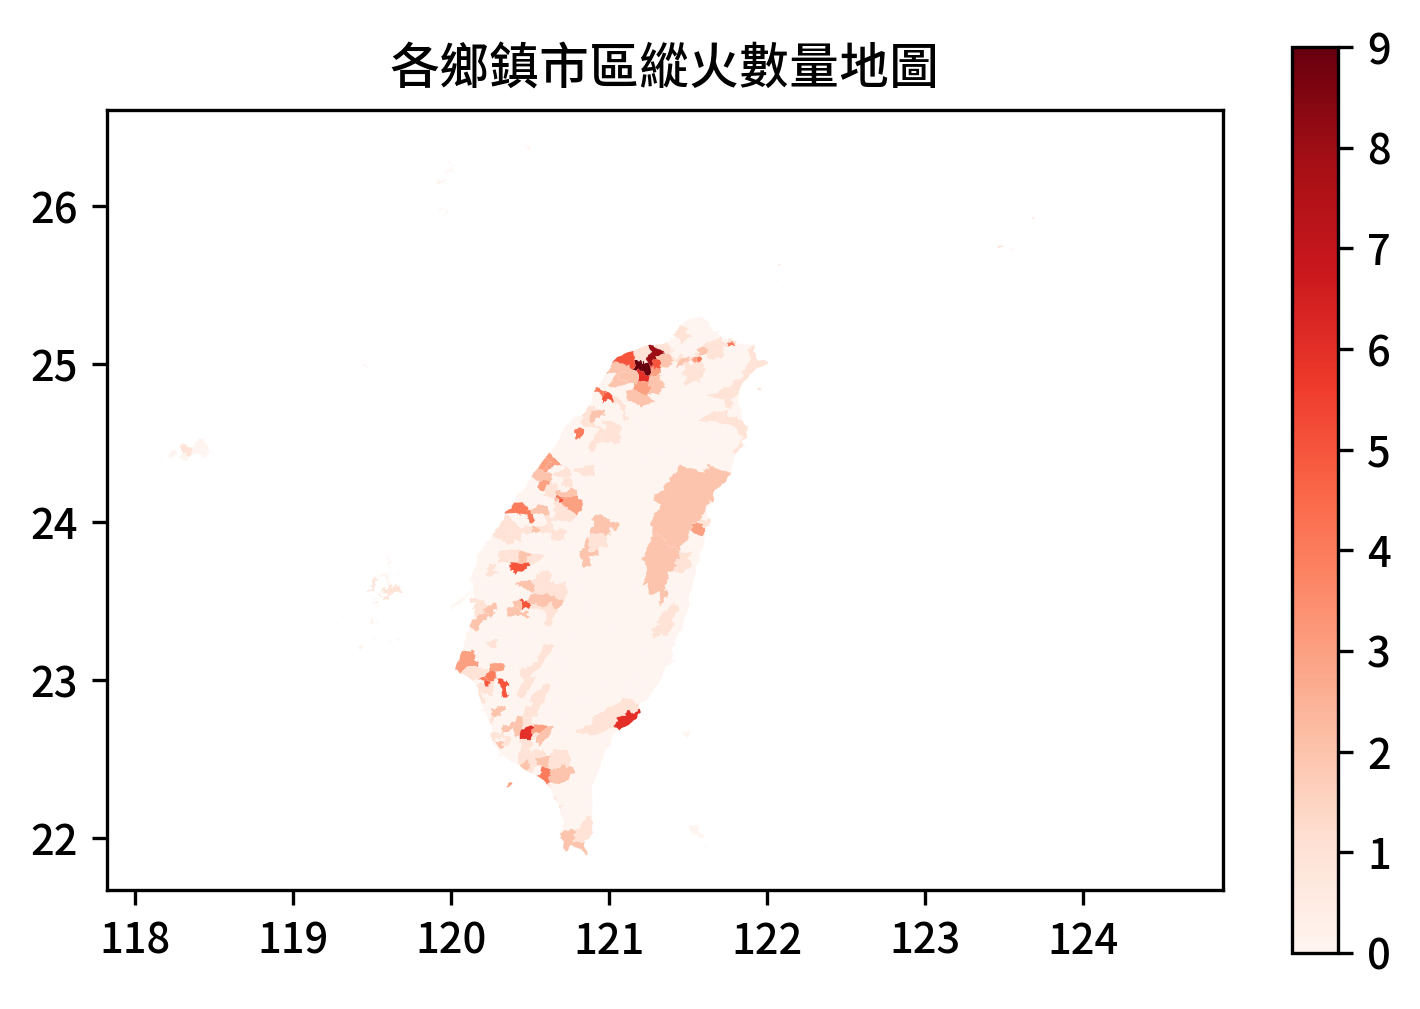

In [27]:
print(subprocess.getoutput('date'))
list_scope = [['COUNTYNAME', '縣市'], ['TOWNNAME', '鄉鎮市區']]
ax = []

for scope in list_scope:
    ax.append(
        taiwan_town_shp.
            dissolve(scope[0], as_index=False)[[scope[0],'geometry']]
                .merge(
                    right = df_Arson_rank.groupby(by = scope[1]).sum(),
                    left_on = [scope[0]],
                    right_index = True,
                    how = 'left').fillna(0)
                .plot(
                    legend=True,  
#                     categorical=True,
                    linewidth = 10,
                    cmap = plt.cm.Reds, #指定顏色
                    column = '縱火', #指定從自身的這個 column 讀取顏色深度,
#                     legend = True, k = 10, scheme = 'Quantiles'
                    )
    )
    plt.title('各{}縱火數量地圖'.format(scope[1]))
plt.show()
print(subprocess.getoutput('date'))

# 考慮人口分佈下的縱火數計算

In [145]:
# 讀取人口分佈資料
df_104_tw_population = pd.read_csv("../dataset/104各鄉鎮市區人口密度.csv")

# 重整 columns
df_104_tw_population.rename_axis(
                        mapper = df_104_tw_population.iloc[0],
                        axis = 1, inplace = True)
df_104_tw_population = df_104_tw_population[1:] #去除多餘資料
df_104_tw_population[360:370]
df_104_tw_population.head()

,統計年,區域別,年底人口數,土地面積,人口密度
1,104,新北市板橋區,554236,23.1373,23954
2,104,新北市三重區,388447,16.317,23806
3,104,新北市中和區,414304,20.144,20567
4,104,新北市永和區,225409,5.7138,39450
5,104,新北市新莊區,413243,19.7383,20936


In [110]:
# 增加一組可以用來對應人口數資料的 column
df_Arson_rank['縣市+鄉鎮市區'] = df_Arson_rank.index.map("{0[0]}{0[1]}".format)

In [178]:
# 1. 合併 各地區人口數目 & 各地區縱火數
# 2. 清除 na
# 3. drop 多餘 columns
df_caclu_arson_and_population = (
            df_Arson_rank.reset_index()
                         .merge(how = 'outer',
                                right = df_104_tw_population, right_on = '區域別',
                                left_on = '縣市+鄉鎮市區')
                         .dropna(subset = ['縣市+鄉鎮市區','區域別'])
                         .drop(labels=['區域別'], axis = 1))

In [179]:
# 4. 計算 縱火數/年底人口數
df_caclu_arson_and_population['縱火數/年底人口數'] = (
             df_caclu_arson_and_population['縱火']/
             df_caclu_arson_and_population['年底人口數'].apply(pd.to_numeric)
)

In [180]:
# 5. 計算 縱火數/土地面積
df_caclu_arson_and_population['縱火數/土地面積'] = (
             df_caclu_arson_and_population['縱火']/
             df_caclu_arson_and_population['土地面積'].apply(pd.to_numeric)
)

In [181]:
# df_caclu_arson_and_population.sort_values(by='縱火數/年底人口數', ascending=False)
df_caclu_arson_and_population.head()

,縣市,鄉鎮市區,縱火,縣市+鄉鎮市區,統計年,年底人口數,土地面積,人口密度,縱火數/年底人口數,縱火數/土地面積
0,桃園市,中壢區,9.0,桃園市中壢區,104,389782,76.52,5094,0.000023,0.117616
1,桃園市,蘆竹區,8.0,桃園市蘆竹區,104,155403,75.5025,2058,0.000051,0.105957
2,桃園市,平鎮區,6.0,桃園市平鎮區,104,217887,47.7532,4563,0.000028,0.125646
3,臺東縣,臺東市,6.0,臺東縣臺東市,104,106759,109.7691,973,0.000056,0.054660
4,屏東縣,屏東市,6.0,屏東縣屏東市,104,202562,65.067,3113,0.000030,0.092213


四  9月 14 17:44:09 CST 2017


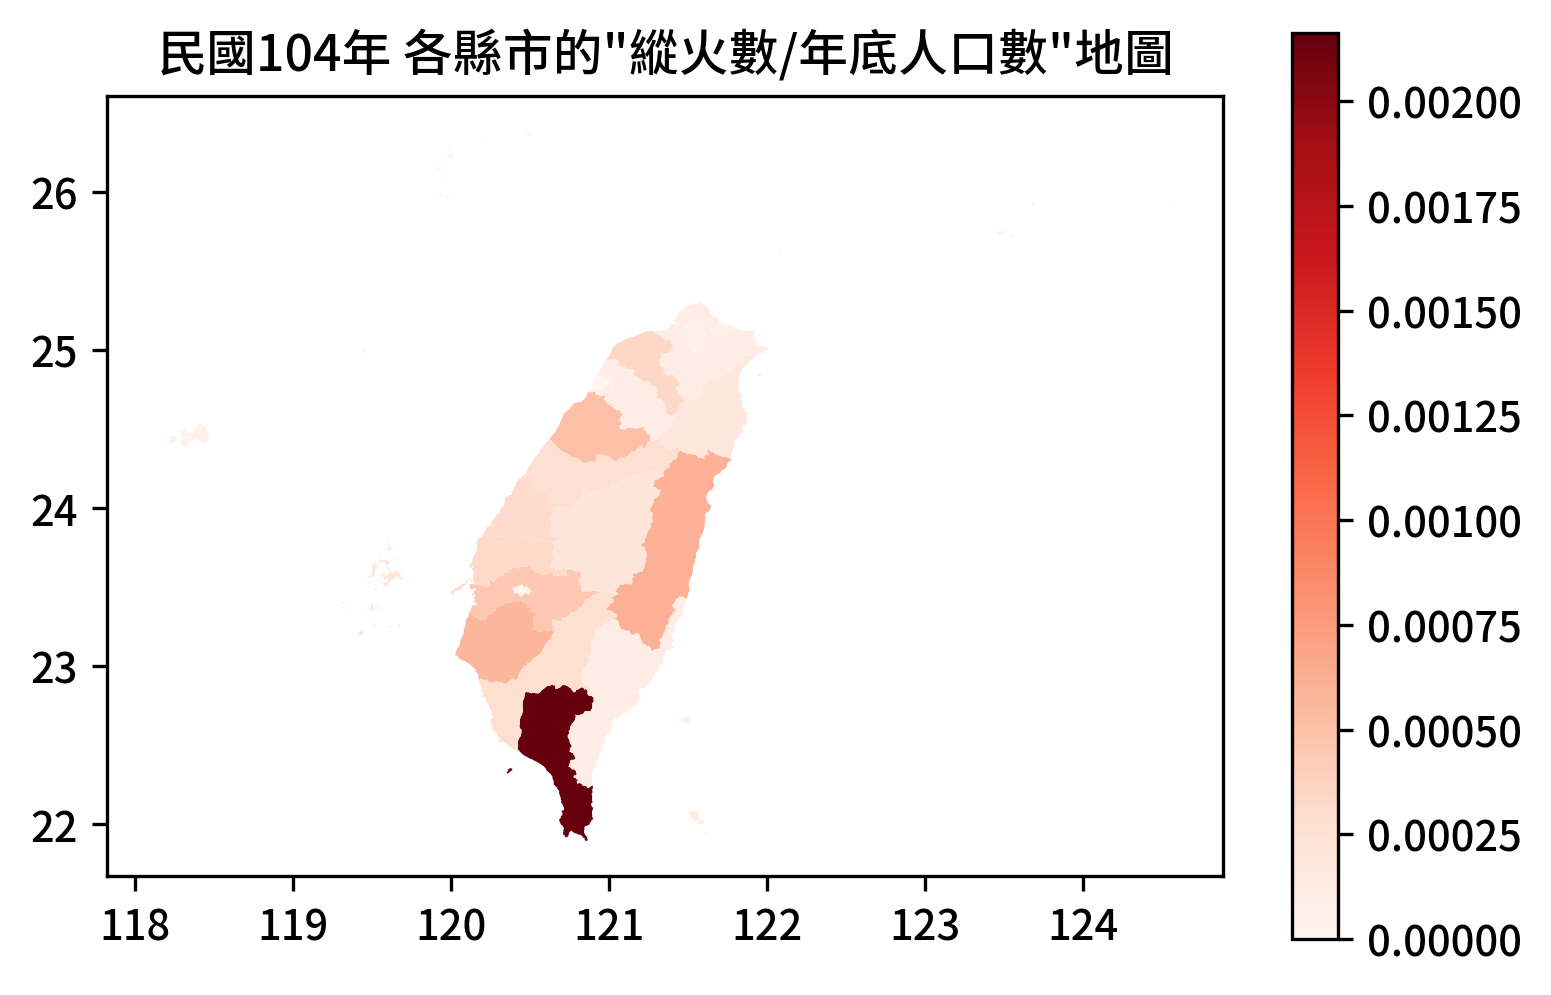

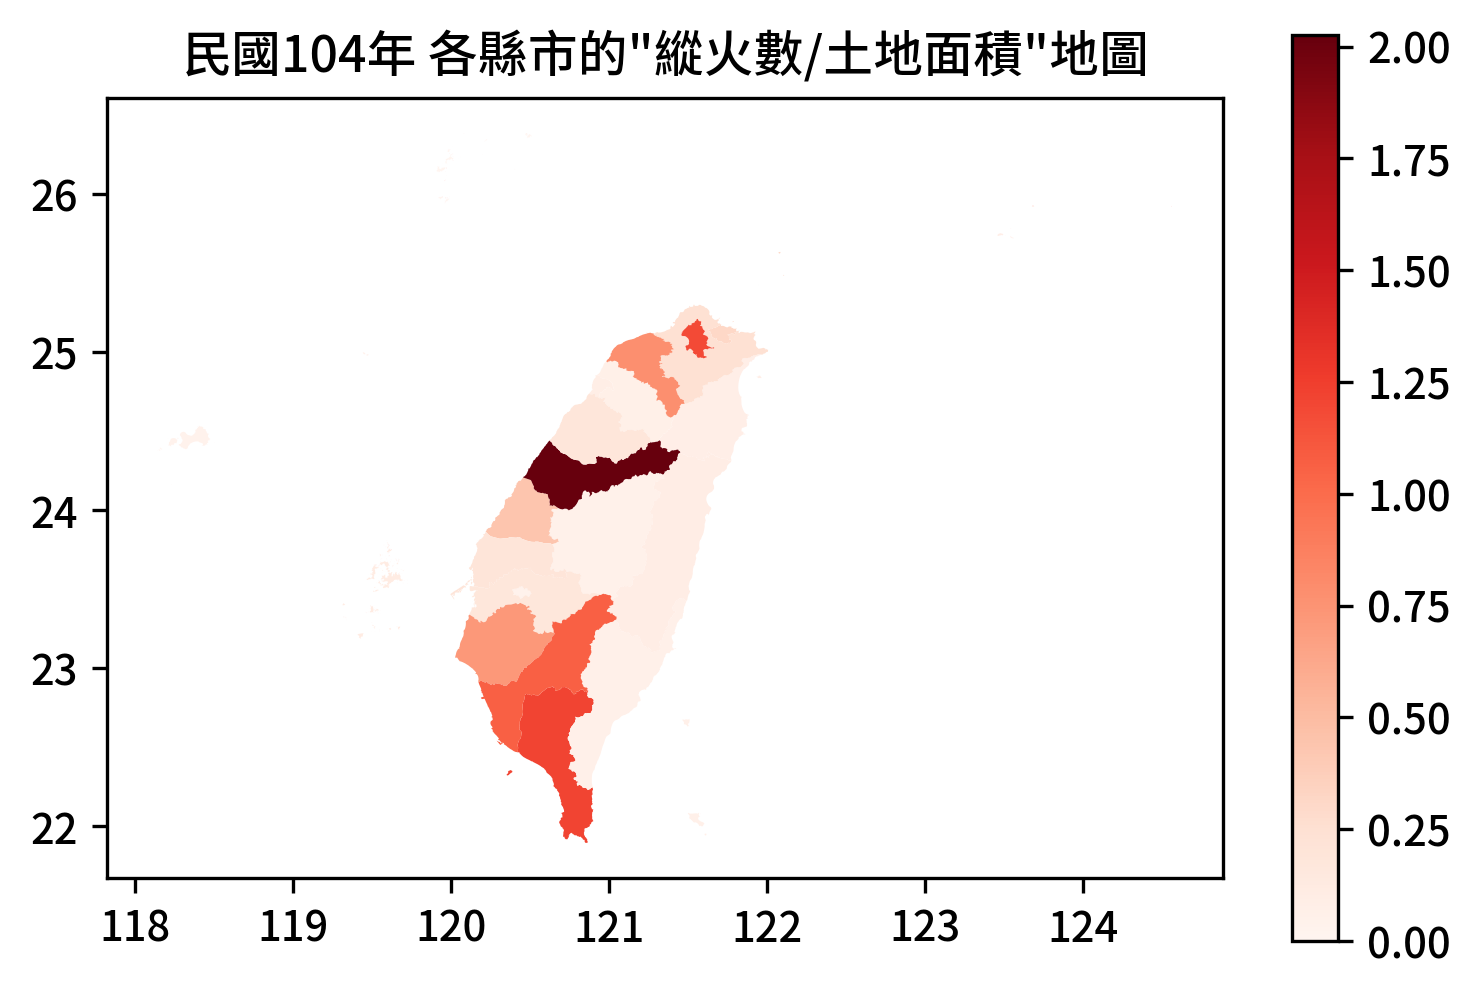

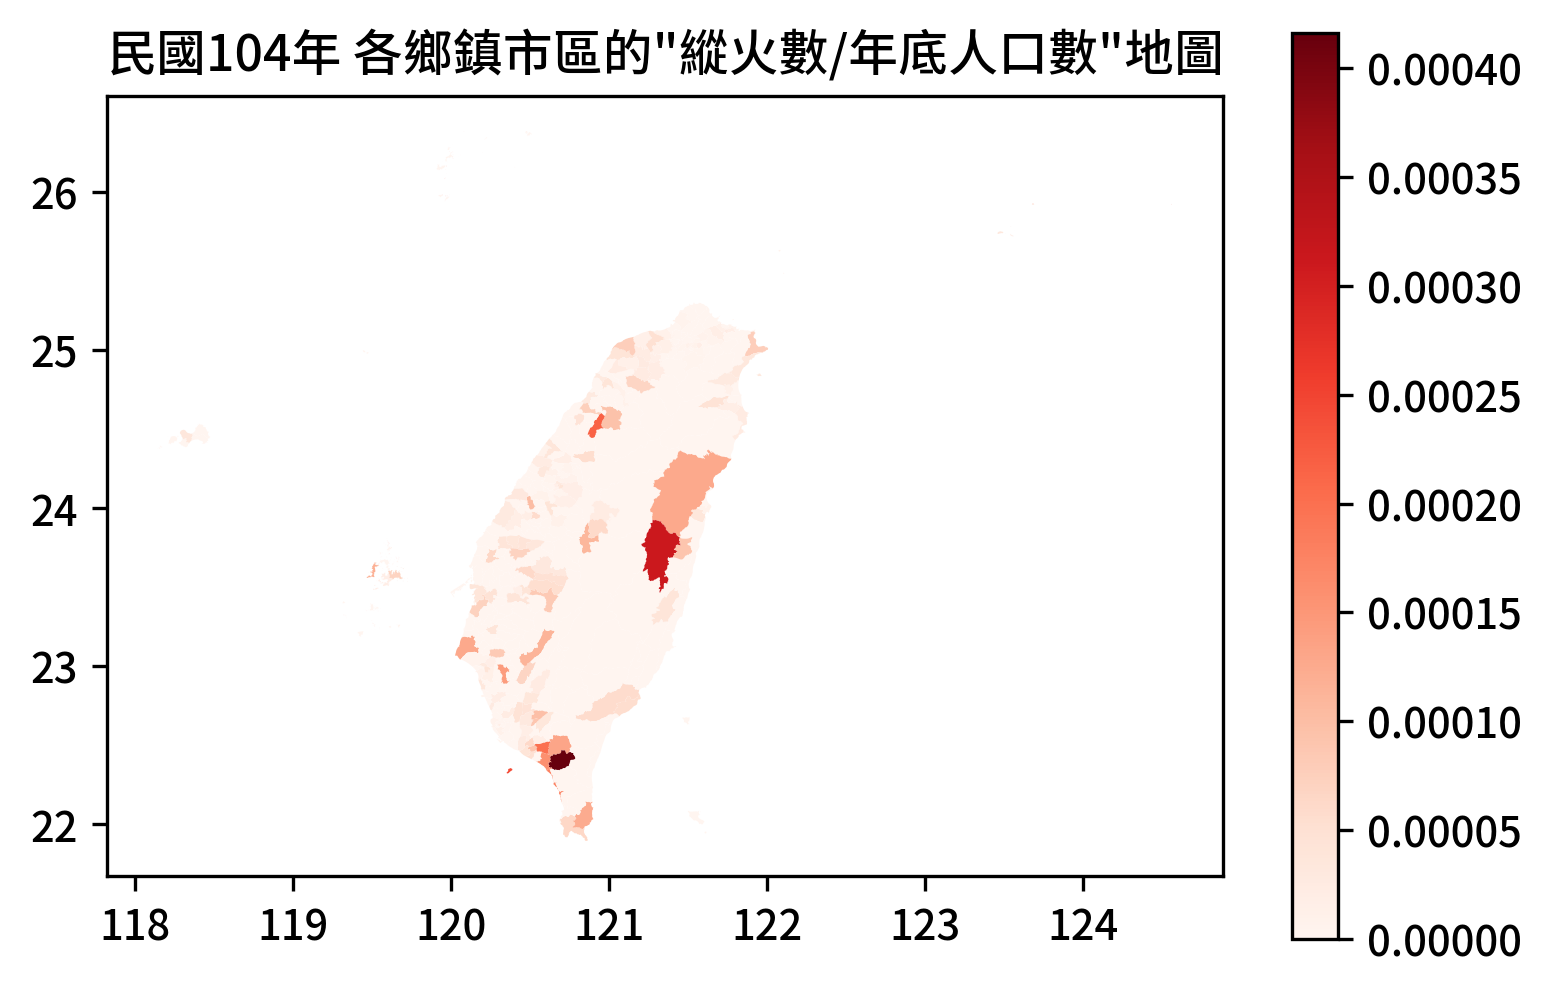

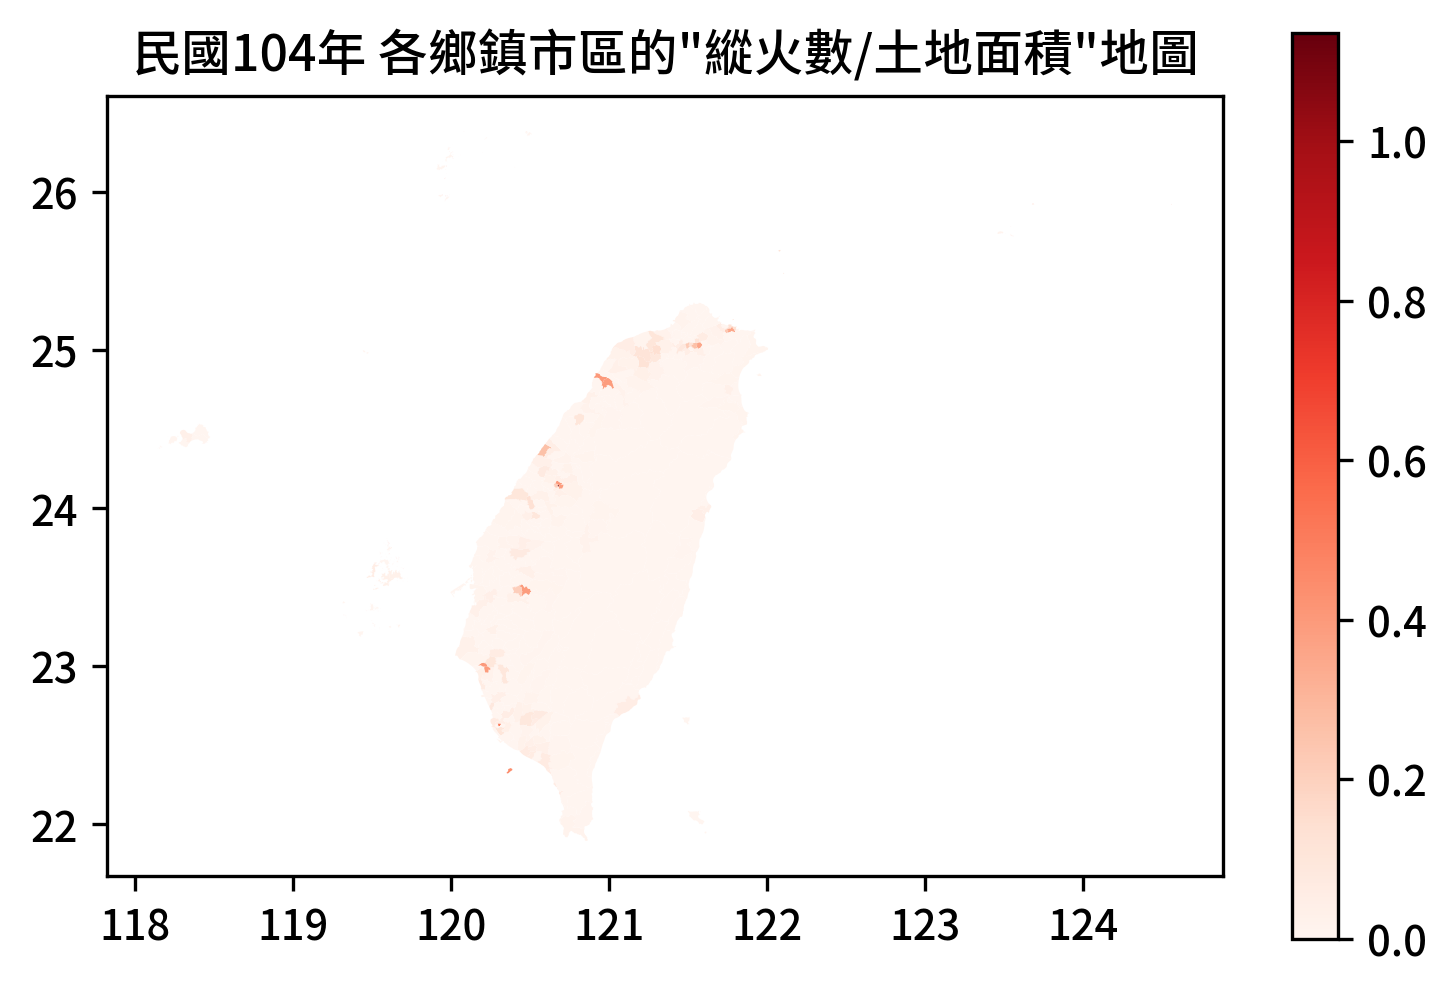

四  9月 14 17:45:20 CST 2017


In [189]:
print(subprocess.getoutput('date'))
list_region_scope = [['COUNTYNAME', '縣市'], ['TOWNNAME', '鄉鎮市區']]
list_event_scope = ['縱火數/年底人口數','縱火數/土地面積']
ax = []

for region in list_region_scope:
    for event in list_event_scope:
        ax.append(
            taiwan_town_shp.
                dissolve(region[0], as_index=False)[[region[0],'geometry']]
                    .merge(
                        right = df_caclu_arson_and_population.groupby(by = region[1]).sum(),
                        left_on = [region[0]],
                        right_index = True,
                        how = 'left').fillna(0)
                    .plot(
                        legend=True,  
    #                     categorical=True,
                        linewidth = 10,
                        cmap = plt.cm.Reds, #指定顏色
                        column = event, #指定從自身的這個 column 讀取顏色深度,
    #                     legend = True, k = 10, scheme = 'Quantiles'
                        )
        )
        plt.title('民國104年 各{}的"{}"地圖'.format(region[1], event))
plt.show()
print(subprocess.getoutput('date'))

## 縱火案件報案時間分佈

In [ ]:
df_taiwan_fire_event.columns

In [ ]:
# df_taiwan_fire_event[['縣市','報案時間 (月：日：時：分) ']]
df_taiwan_fire_event.iloc[[1,9],:]